# pythagoras

Welcome to _pythagoras_. For more information about the project, visit the [project website](web.simmons.edu/~bellanti/pythagoras) or the Github repo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
import re
from collections import Counter
%matplotlib inline

In [2]:
xml_filepath = "./scores/JSB_BWV1047_1.xml"

In [ ]:
# with open(xml_filepath, 'r') as xml_file:
#     for line in xml_file:
#         print(line.rstrip())

In [3]:
tree = etree.parse(xml_filepath)
root = tree.getroot()
notes = []
count = 0
for e in root.xpath('//note'):
    
    part = e.xpath('../..//@id')[0]
    
    measure = e.xpath('..//@number')[0]
    
    dotted = True if 'dot' in [child.tag for child in e] else False

    rest = True if 'rest' in [child.tag for child in e] else False
    
    duration_list = e.xpath('.//duration/text()')
    duration = duration_list[0] if len(duration_list)>0 else ''
    
    typ_list = e.xpath('.//type/text()')
    typ = typ_list[0] if len(typ_list)>0 else ''

    
    step_list = e.xpath('.//step/text()')
    step = step_list[0] if len(step_list)>0 else ''
    
    alter_list = e.xpath('.//alter/text()')
    alter = alter_list[0] if len(alter_list)>0 else ''
    
    octave_list = e.xpath('.//octave/text()')
    octave = octave_list[0] if len(step_list)>0 else ''
    
#     print("\t".join([str(count),part,str(measure),step,octave,duration,typ,dotted,rest]))
    notes.append((part,measure,step,alter,octave,duration,typ,dotted,rest))
    count += 1

In [4]:
df = pd.DataFrame(notes,columns=['part','measure','step','alter','octave','duration','type','dotted','rest'])

In [ ]:
print(len(df[df['alter'] == '1']))

Text(0,0.5,'Group')

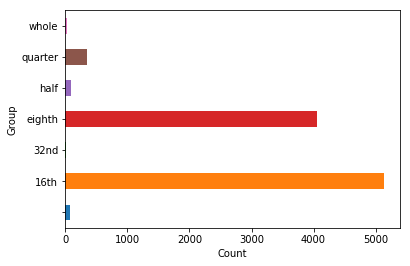

In [7]:
col = 'type'
df.groupby(col).type.count().plot.barh()
plt.xlabel('Count')
plt.ylabel('Group')


In [9]:
steps = df['step'].to_string(index=False)
steps = re.sub(r'\n|\t| ','',steps)
print(steps)

FACAFACFCACAFACFGABCCCCCCFFCCAAFFFFCCAAFFCCCCCCCCCFCAFCAFACAFACFCACAFACFCCDEDCDEDCBCDEFEDCDEDCDEDCCCCDEDCDEDCBCDEFEDCDEDCDEDCCGABABBABCBCDCBAGAGACBAGFGCGGGGGGGGGGGGGGCBCGGEDEGGCBCGGEDEGAGCBGAGCCCDEDEEDEFFGABCADBGBCGCBABCAFAAAADABBGCGAAFBFGGFGAGFDCDAAFEFAADCDAAFEFAAAAAAAAAAFAAFGAFGADADAFGAFGADADCBAGABAGABCBAGAGABAGABAGABCBAGCFCACFCACFCACFCCCCCCCCCCCCFACFCAFAAAAAAAADDDDDDDDDEFEDEDCBCDCBCDEACEDCAGFCBAGFEFBABFFDCDFFBABFFDCDFFFFFFFFBCBCCBBGABABBABCBCDCDECDEDCBAGFEFGECCEGECEGCGEGECEGCGGGGGGGGGGGGBBBBBBBAFACFCAFAAAAAAAABGABGABDBDBGABGABDGDECFCDBEBCADCBGBDGDBDBGBDGDBGGABAGABGABCBAGAGABAGABGABCBAGAAAAAAAAAAAAAAFGAFGADADAFGADBDBDCGCGACACBCBCDCBADDDBCCCABABCDCBDCDECACCABCABCECECABCAACACGBGBGBGBFAFAFAFDBAAAAFCAFCAFCFCFCAFCAFCFCCCCCCCCCCCCCFFFFFFFFGGGGGGGGGCGGCGGCAAAAAAAAAAAAAAAAFFFFFFFFCGFGCCCBCCCGFGCCCBCFGFCCAAFFFFCCAAFFCCCCCCCCCFCAFCAFCABCABCFCFCABCABCFCFGFGABABAGFEDCFEFGFGABABAGFEDCBAGFAGFCBAFCBAGFAGFCBAFCDEFGABGAFCFGABGBFCBAGFCEFEDCBAGFFCABCABCFCFCABCABCFCAGEFGEFGCGCGEFGEFGCGGABABBABCCDEFGEAFD

## Match patterns
Using the string generated from the dataframe series, match any reoccuring patterns longer than a given length.

In [10]:
length = 8
pat = r'(?=(.{%d,})(?=.*\1))' % length

step_patterns = re.findall(pat,steps)

print(Counter(step_patterns))

Counter({'AAAAAAAA': 12, 'EEEEEEEEE': 8, 'GGGGGGGG': 7, 'GGGGGGGGGGGG': 4, 'CCCCCCCCC': 4, 'CCCCCCCC': 4, 'GFEDCBAGF': 4, 'FEDEFEDEFEDE': 4, 'FEDCBAGF': 4, 'GFGGFGGFG': 4, 'AAAAAAAF': 3, 'DDDDDDDD': 3, 'FFFFFFFF': 3, 'DCBAGFEDC': 3, 'CBAGFEDC': 3, 'GFGABABAGFEDCFEFGFGABABAGFEDC': 3, 'FGABABAGFEDCFEFGFGABABAGFEDC': 3, 'GABABAGFEDCFEFGFGABABAGFEDC': 3, 'ABABAGFEDCFEFGFGABABAGFEDC': 3, 'BABAGFEDCFEFGFGABABAGFEDC': 3, 'ABAGFEDCFEFGFGABABAGFEDC': 3, 'BAGFEDCFEFGFGABABAGFEDC': 3, 'AGFEDCFEFGFGABABAGFEDC': 3, 'GFEDCFEFGFGABABAGFEDC': 3, 'FEDCFEFGFGABABAGFEDC': 3, 'EDCFEFGFGABABAGFEDC': 3, 'DCFEFGFGABABAGFEDC': 3, 'CFEFGFGABABAGFEDC': 3, 'FEFGFGABABAGFEDC': 3, 'EFGFGABABAGFEDC': 3, 'FGFGABABAGFEDC': 3, 'GFGABABAGFEDC': 3, 'FGABABAGFEDC': 3, 'GABABAGFEDC': 3, 'ABABAGFEDC': 3, 'BABAGFEDC': 3, 'ABAGFEDC': 3, 'FCDECDBFBCDECDBFEDCBFAB': 3, 'CDECDBFBCDECDBFEDCBFAB': 3, 'DECDBFBCDECDBFEDCBFAB': 3, 'ECDBFBCDECDBFEDCBFAB': 3, 'CDBFBCDECDBFEDCBFAB': 3, 'DBFBCDECDBFEDCBFAB': 3, 'BFBCDECDBFEDCBFAB': 3, 'F